In [4]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [5]:
observed_emotions=['calm', 'happy', 'sad', 'angry']

In [11]:
all_emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

def load_data(filepath):
    x, y = [],[]
    for file in glob.glob(filepath + "/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=all_emotions[file_name.split("-")[2]]
        
        if emotion not in observed_emotions:
            continue
        
        with soundfile.SoundFile(file) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate

            stft=np.abs(librosa.stft(X))
            feature=np.array([])

            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            feature=np.hstack((feature, mfccs))

            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            feature=np.hstack((feature, chroma))
            
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            feature=np.hstack((feature, mel))

        x.append(feature)
        y.append(emotion)

    return np.array(x), y

In [12]:
X, y = load_data("./data")
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
print((x_train.shape[0], x_test.shape[0]))

(614, 154)


In [14]:
print('Features extracted:', x_train.shape[1])

Features extracted: 180


## 1. Multilayer perceptron

In [8]:
def MLP(x_train, y_train):
    # define the multinomial logistic regression model
    model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

    return n_scores

In [9]:
scores = MLP(x_train, y_train)

In [10]:
scores

array([0.67741935, 0.67741935, 0.51612903, 0.56451613, 0.63934426,
       0.55737705, 0.68852459, 0.67213115, 0.62295082, 0.54098361,
       0.64516129, 0.62903226, 0.69354839, 0.56451613, 0.67213115,
       0.68852459, 0.54098361, 0.67213115, 0.70491803, 0.52459016,
       0.46774194, 0.61290323, 0.56451613, 0.51612903, 0.63934426,
       0.6557377 , 0.54098361, 0.70491803, 0.72131148, 0.80327869])

In [11]:
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.624 (0.077)


In [12]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [13]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [14]:
y_pred=model.predict(x_test)

In [15]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 70.13%


In [16]:
f1=f1_score(y_true=y_test, y_pred=y_pred, average="macro")
f1

0.6911935466023946

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.84      0.68      0.75        38
        calm       0.62      0.95      0.75        40
       happy       0.64      0.77      0.70        35
         sad       0.85      0.41      0.56        41

    accuracy                           0.70       154
   macro avg       0.74      0.71      0.69       154
weighted avg       0.74      0.70      0.69       154



## 2. Logistic regression

In [18]:
def logistic_regression(x_train, y_train):
    # define the multinomial logistic regression model
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=500,  penalty='l2')
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

    return n_scores

In [19]:
scores = logistic_regression(x_train, y_train)

In [20]:
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.635 (0.053)


In [21]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=500,  penalty='l2')

In [22]:
model.fit(x_train,y_train)

LogisticRegression(max_iter=500, multi_class='multinomial', solver='newton-cg')

In [23]:
y_pred=model.predict(x_test)

In [24]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 61.69%


In [25]:
f1=f1_score(y_true=y_test, y_pred=y_pred, average="macro")
f1

0.616922118082222

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.68      0.71        38
        calm       0.65      0.75      0.70        40
       happy       0.61      0.54      0.58        35
         sad       0.48      0.49      0.48        41

    accuracy                           0.62       154
   macro avg       0.62      0.62      0.62       154
weighted avg       0.62      0.62      0.62       154



## 3. SVM

In [27]:
def SVM(x_train, y_train):
    # define the multinomial logistic regression model
    model = svm.SVC(kernel='poly', gamma=0.5, C=0.1)
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

    return n_scores

In [28]:
scores = SVM(x_train, y_train)

In [29]:
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.677 (0.054)


In [30]:
scores

array([0.67741935, 0.64516129, 0.59677419, 0.58064516, 0.6557377 ,
       0.7704918 , 0.70491803, 0.72131148, 0.63934426, 0.68852459,
       0.75806452, 0.66129032, 0.64516129, 0.67741935, 0.6557377 ,
       0.70491803, 0.80327869, 0.57377049, 0.62295082, 0.6557377 ,
       0.67741935, 0.67741935, 0.64516129, 0.64516129, 0.68852459,
       0.6557377 , 0.63934426, 0.73770492, 0.72131148, 0.7704918 ])

In [31]:
model = svm.SVC(kernel='poly', gamma=0.5, C=0.1)

In [32]:
model.fit(x_train,y_train)

SVC(C=0.1, gamma=0.5, kernel='poly')

In [33]:
y_pred=model.predict(x_test)

In [34]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 69.48%


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.77      0.79      0.78        38
        calm       0.66      0.78      0.71        40
       happy       0.69      0.63      0.66        35
         sad       0.67      0.59      0.62        41

    accuracy                           0.69       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.69      0.69      0.69       154



## 2. Random forest

In [15]:
def random_forest(x_train, y_train):
    # define the multinomial logistic regression model
    model = RandomForestClassifier(n_estimators=120)
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

    return n_scores

In [16]:
scores = random_forest(x_train, y_train)

In [17]:
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.708 (0.051)


In [18]:
model = RandomForestClassifier(n_estimators=120, random_state=7)

In [19]:
model.fit(x_train,y_train)

RandomForestClassifier(n_estimators=120, random_state=7)

In [20]:
y_pred=model.predict(x_test)

In [21]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 70.78%


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.88      0.83      0.86        36
        calm       0.52      0.89      0.66        28
       happy       0.76      0.67      0.71        46
         sad       0.74      0.52      0.61        44

    accuracy                           0.71       154
   macro avg       0.73      0.73      0.71       154
weighted avg       0.74      0.71      0.71       154



In [58]:
def plot_roc_multiclass(y_score, y_test, classes):
    """
    Plot multiclass ROC curve and calculate AUC for each class
    :param y_score: predicted data
    :param y_test: testing target array
    :param classifier: logistic regression classifier
    :param classes: unique classes of target array
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # binary representation of y_test for calculating micro average
    binary_y_test = []

    for idx, i in enumerate(classes):
        # array of 0 and 1 when 1 represents positions where value is equal to current (i-th) target
        target_arr = [1 if x == i else 0 for x in y_test]

        # calculating roc and auc
        tpr[idx], fpr[idx], _ = roc_curve(target_arr, y_score[:, idx])
        roc_auc[idx] = auc(fpr[idx], tpr[idx])

        # appending binary target array
        binary_y_test.append(target_arr)

    binary_y_test = np.array(binary_y_test)  # convert to numpy array

    # compute micro-average ROC curve and ROC area
    tpr["micro"], fpr["micro"], _ = roc_curve(binary_y_test.ravel(order='F'), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # plot ROC curve
    plt.figure(figsize=(8, 6), dpi=200, facecolor='white')
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2)

    # for idx, i in enumerate(classes):
    #     plt.plot(fpr[idx], tpr[idx], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[idx]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR (1 - specificity)')
    plt.ylabel('TPR (sensitivity)')
    plt.legend(loc="lower right")
    plt.savefig('visualizations/roc.png', format='png', bbox_inches='tight')
    plt.show()

In [59]:
y_score = model.predict_proba(x_test)

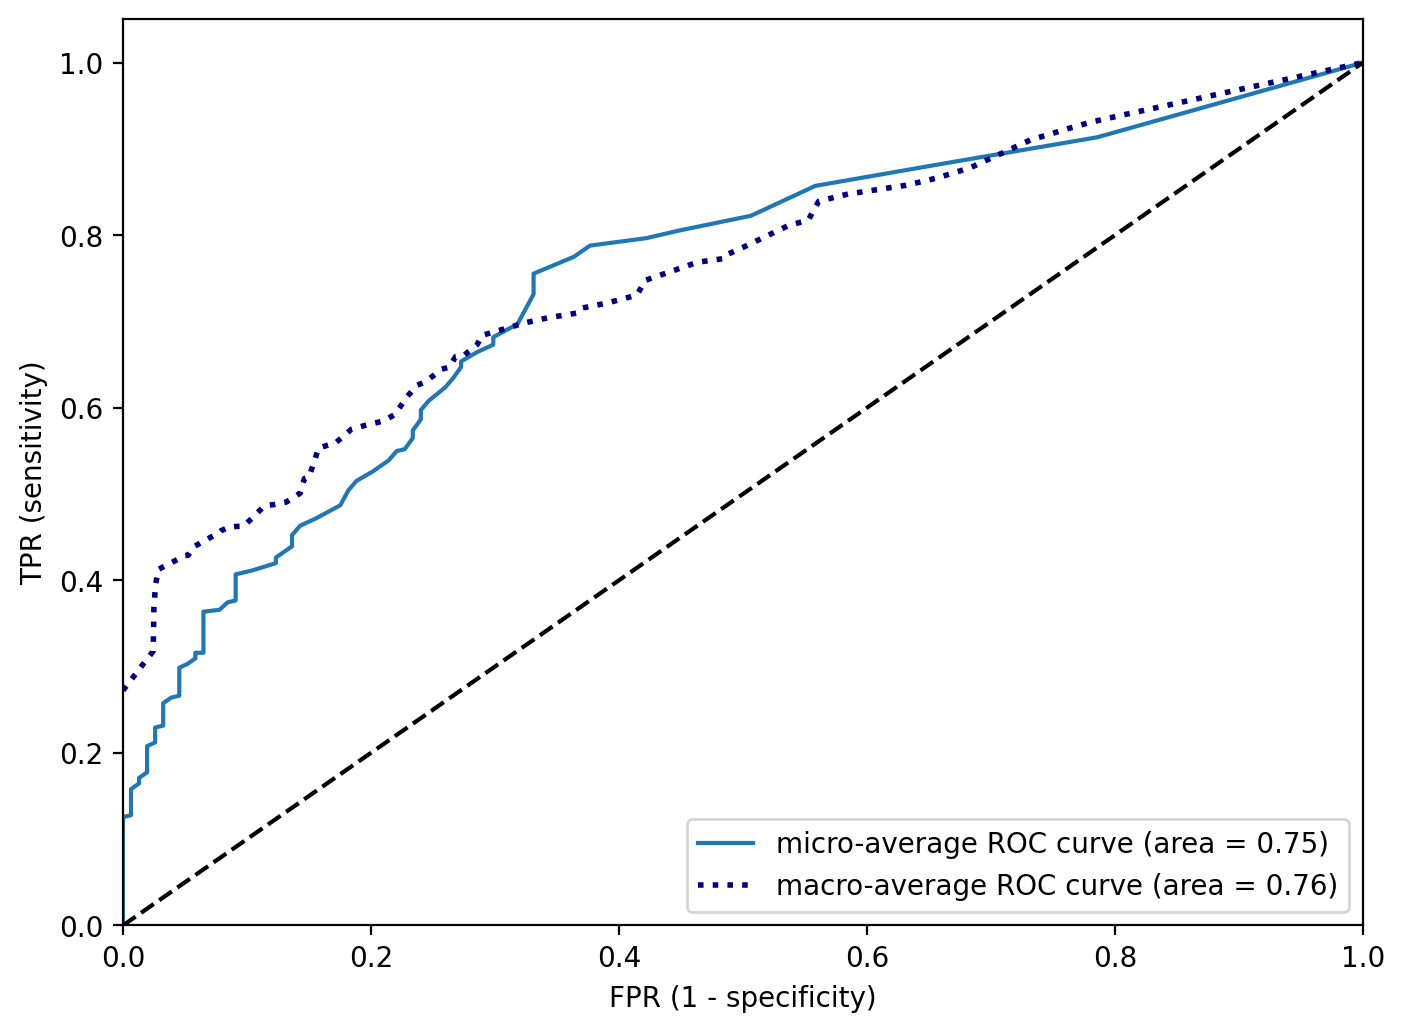

In [60]:
plot_roc_multiclass(y_score, y_test, observed_emotions)